# Introduction

The goal of this study is to see the emerging markets in the Retail Shop Datasets through cluster analysis.

# 1. Cleaning the Datasets
There are 3 datasets for this study: customers, product categories and transactions. Some columns of the datasets were transformed to lowercase and renamed for easier understanding. Rows with null values were also dropped since they would give no value at all.

At the end of this section, these three are merged into one dataset using SQL syntax enabled by the pandasql library.

In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image
from IPython.core.display import HTML 

sns.set(rc={'figure.figsize':(10,10)})

%matplotlib inline

In [2]:
# Load the csv datasets into pandas dataframes
dataset_dir = os.path.join(os.getcwd(), 'dataset')

In [3]:
# Create a function to drop rows from a dataframe. This will be used throughout this notebook.
# rows_to_drop = transact_df[transact_df['qty'] < 1].index
# transact_df.drop(rows_to_drop, axis=0, inplace=True)
# transact_df.reset_index(drop=True, inplace=True)

def drop_rows_reset_index_inplace(rows_index, dataframe):
    dataframe.drop(rows_index, axis=0, inplace=True)
    dataframe.reset_index(drop=True, inplace=True)


## 1.1. The Customers Dataset

In [4]:
customer_csv = os.path.join(dataset_dir, 'Customer.csv')
customer_df = pd.read_csv(customer_csv)

In [5]:
customer_df_col_map = {
    'customer_Id': 'customer_id',
    'DOB': 'birth_year',
    'Gender': 'gender'
}
customer_df.rename(columns=customer_df_col_map, inplace=True)

In [6]:
# Check for and drop the rows with null values
customer_df.isna().sum()

customer_id    0
birth_year     0
gender         2
city_code      2
dtype: int64

In [7]:
customer_df.dropna(inplace=True)
customer_df.reset_index(drop=True, inplace=True)

In [8]:
# Transform the former DOB column to Year only
customer_df['birth_year'] = customer_df['birth_year'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y').year)

In [9]:
customer_df.head()

,customer_id,birth_year,gender,city_code
0,268408,1970,M,4.0
1,269696,1970,F,8.0
2,268159,1970,F,8.0
3,270181,1970,F,2.0
4,268073,1970,M,1.0


## 1.2. Product Categories Dataset

In [10]:
prodcat_csv = os.path.join(dataset_dir, 'prod_cat_info.csv')
prodcat_df = pd.read_csv(prodcat_csv)

In [11]:
# Rename column prod_subcat to prod_sub_cat for consistency
prodcat_df.rename(columns={'prod_subcat': 'prod_sub_cat'}, inplace=True)

Notice that "prod_cat" column with values "Clothing", "Footwear" and "Bags" all have the same "prod_sub_cat" values. To avoid confusion later on in the clustering, the "prod_sub_cat" values must be unique.

In [12]:
prodcat_df[prodcat_df['prod_cat'].isin(["Clothing", "Footwear", "Bags"])]

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_sub_cat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids
3,2,Footwear,1,Mens
4,2,Footwear,3,Women
5,2,Footwear,4,Kids
11,4,Bags,1,Mens
12,4,Bags,4,Women


Function rename_prod_sub_cat is created to transform the "prod_sub_cat" values.

In [13]:
def rename_prod_sub_cat(prod_cat, old_sub_cat, new_sub_cat):
    # Locate the row that corresponds to parm prod_cat and old_sub_cat
    # Replace the prod_sub_cat of that row with the new_sub_cat
    prodcat_df.loc[(prodcat_df['prod_cat'] == prod_cat) &
                   (prodcat_df['prod_sub_cat'] == old_sub_cat),
                   'prod_sub_cat'] = new_sub_cat

The dictionary 'prod_sub_cat_names' contains the constants to use for the function. Loop its key's and values and pass them to the function.

In [14]:
prod_sub_cat_names = {
    # new_sub_cat : [prod_cat, old_sub_cat]
    'clothing_men': ['Clothing', 'Mens'],
    'clothing_women': ['Clothing', 'Women'],
    'clothing_kids': ['Clothing', 'Kids'],
    'footwear_men': ['Footwear', 'Mens'],
    'footwear_women': ['Footwear', 'Women'],
    'footwear_kids': ['Footwear', 'Kids'],
    'bags_men': ['Bags', 'Mens'],
    'bags_women': ['Bags', 'Women'],
}

for key, val_list in prod_sub_cat_names.items():
    rename_prod_sub_cat(prod_cat=val_list[0], old_sub_cat=val_list[1], new_sub_cat=key)

In [15]:
# Convert the rest of prod_sub_cat values to lowercase
prodcat_df['prod_sub_cat'] = prodcat_df['prod_sub_cat'].str.lower()

In [16]:
print(prodcat_df)

    prod_cat_code          prod_cat  prod_sub_cat_code         prod_sub_cat
0               1          Clothing                  4         clothing_men
1               1          Clothing                  1       clothing_women
2               1          Clothing                  3        clothing_kids
3               2          Footwear                  1         footwear_men
4               2          Footwear                  3       footwear_women
5               2          Footwear                  4        footwear_kids
6               3       Electronics                  4              mobiles
7               3       Electronics                  5            computers
8               3       Electronics                  8  personal appliances
9               3       Electronics                  9              cameras
10              3       Electronics                 10      audio and video
11              4              Bags                  1             bags_men
12          

## 1.3. Transactions Dataset

In [17]:
transact_csv = os.path.join(dataset_dir, 'Transactions.csv')
transact_df = pd.read_csv(transact_csv)

In [18]:
# Set to lowercase these columns of transact_df for easier reference
transact_df_col_map = {
    'cust_id': 'customer_id',
    'prod_subcat_code': 'prod_sub_cat_code',
    'Qty': 'qty',
    'Rate': 'rate',
    'Tax': 'tax',
    'Store_type': 'store_type',
    'tran_date': 'transact_date'
}
transact_df.rename(columns=transact_df_col_map, inplace=True)

There are some transactions where the "qty" columns is less than 1. These can be interpreted as returns or refunds. However, since this study aims to know the emerging markets, these refund rows will be dropped. 

In [19]:
transact_df[transact_df['qty'] < 1].head()

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop


In [20]:
# Remove the rows where qty is less than 1
rows_to_drop = transact_df[transact_df['qty'] < 1].index
drop_rows_reset_index_inplace(rows_to_drop, transact_df)

Convert "transact_date" to a datetime object. This column has a mix of dates formatted in DD-MM-YYYY and DD/MM/YYYY, so pandas.to_datetime with dayfirst=True param is used

In [21]:
transact_df['transact_date'] = pd.to_datetime(transact_df['transact_date'], dayfirst=True)

Create new columns transact_year and transact_month that are derived from transact_date.

In [22]:
transact_df['transact_year'] = transact_df['transact_date'].dt.year
transact_df['transact_month'] = transact_df['transact_date'].dt.month

In [23]:
transact_df.head()

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type,transact_year,transact_month
0,29258453508,270384,2014-02-20,5,3,5,1497,785.925,8270.925,e-Shop,2014,2
1,25455265351,267750,2014-02-20,12,6,3,1360,428.400,4508.400,e-Shop,2014,2
2,1571002198,275023,2014-02-20,6,5,4,587,246.540,2594.540,e-Shop,2014,2
3,36554696014,269345,2014-02-20,3,5,3,1253,394.695,4153.695,e-Shop,2014,2
4,56814940239,268799,2014-02-20,7,5,5,368,193.200,2033.200,e-Shop,2014,2


## 1.4. Merging the Datasets
The library pandasql is used to join the three datasets together using SQL. This is more precise and easier to read, because the SQL Joins allow more control than pandas.

In [24]:
# Use pandasql to easily merge the three datasets together
from pandasql import sqldf

In [25]:
merged_df = lambda query: sqldf(query, globals())
query = """
    SELECT
        t.*,
        c.birth_year,
        c.gender,
        c.city_code,
        p.prod_cat,
        p.prod_sub_cat
    FROM transact_df t
    INNER JOIN customer_df c
        on c.customer_id = t.customer_id
    INNER JOIN prodcat_df p
        ON p.prod_cat_code = t.prod_cat_code
        AND p.prod_sub_cat_code = t.prod_sub_cat_code
"""
merged_df = merged_df(query)

In [26]:
merged_df.head()

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type,transact_year,transact_month,birth_year,gender,city_code,prod_cat,prod_sub_cat
0,29258453508,270384,2014-02-20 00:00:00.000000,5,3,5,1497,785.925,8270.925,e-Shop,2014,2,1973,F,8.0,Electronics,computers
1,25455265351,267750,2014-02-20 00:00:00.000000,12,6,3,1360,428.400,4508.400,e-Shop,2014,2,1986,M,1.0,Home and kitchen,tools
2,1571002198,275023,2014-02-20 00:00:00.000000,6,5,4,587,246.540,2594.540,e-Shop,2014,2,1971,M,6.0,Books,diy
3,36554696014,269345,2014-02-20 00:00:00.000000,3,5,3,1253,394.695,4153.695,e-Shop,2014,2,1970,F,10.0,Books,comics
4,56814940239,268799,2014-02-20 00:00:00.000000,7,5,5,368,193.200,2033.200,e-Shop,2014,2,1979,M,9.0,Books,fiction


# 2. Exploring the Data
The goal is to find out which emerging market to look out for. As I narrowed the criteria, I trimmed the merged dataset until I got the ideal dataset for clustering. Aside from having a defined scope, this section also helped me run cluster analysis in R successfully with the hardware specifications of my machine.

## 2.1 Exploring the Merged Dataset

The merged_df has 19,905 rows. This needs to be narrowed down as mentioned above.

In [27]:
merged_df.shape

(20860, 17)

As the 2014 transactions are up to Feburary only, remove all 2014 transactions from the dataframe.

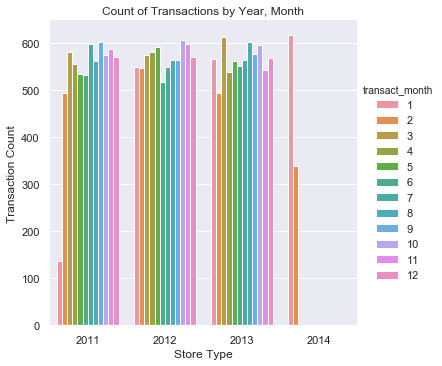

In [28]:
fig = sns.catplot(x='transact_year', kind='count', hue='transact_month' ,data=merged_df )
fig.set(xlabel='Store Type', ylabel="Transaction Count", title="Count of Transactions by Year, Month");

In [29]:
rows_to_drop = merged_df[merged_df['transact_year'] == 2014].index
drop_rows_reset_index_inplace(rows_to_drop, merged_df)

Majority of the transactions come from the 'e-Shop'. The number of rows to analyze is significant enough to focus only on the e-Shop.

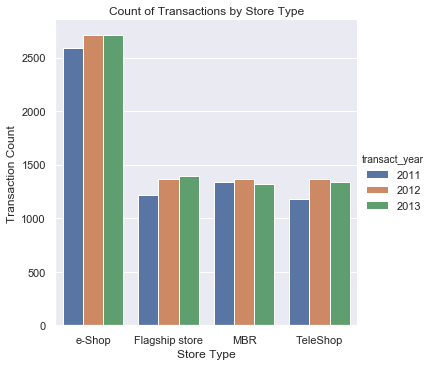

In [30]:
fig = sns.catplot(x='store_type', kind='count', hue='transact_year', data=merged_df )
fig.set(xlabel='Store Type', ylabel="Transaction Count",title="Count of Transactions by Store Type");

In addition, the total sales from the e-Shop is the highest among the store types. 

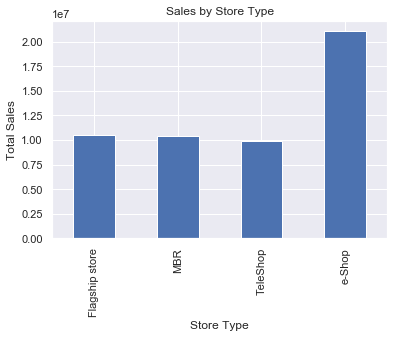

In [31]:
bar = merged_df.groupby('store_type').total_amt.sum().plot(kind='bar');
bar.set_title('Sales by Store Type')
bar.set_ylabel('Total Sales')
bar.set_xlabel('Store Type');

With these, a new dataframe called <b>"eshop_df"</b> is created. It is a copy of the "merged_df", but it will only contain rows where "store_type" is equal to "e_Shop".

In [32]:
eshop_df = merged_df.copy(deep=True)
rows_to_drop = eshop_df[eshop_df['store_type'] != 'e-Shop'].index
drop_rows_reset_index_inplace(rows_to_drop, eshop_df)
eshop_df.head()

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type,transact_year,transact_month,birth_year,gender,city_code,prod_cat,prod_sub_cat
0,58387181112,275068,2013-12-31 00:00:00.000000,8,3,5,792,415.800,4375.800,e-Shop,2013,12,1982,M,2.0,Electronics,personal appliances
1,26100869804,273836,2013-12-31 00:00:00.000000,9,3,3,843,265.545,2794.545,e-Shop,2013,12,1983,M,10.0,Electronics,cameras
2,4116412179,269788,2013-12-31 00:00:00.000000,10,3,3,984,309.960,3261.960,e-Shop,2013,12,1984,F,1.0,Electronics,audio and video
3,51849180620,273963,2013-12-31 00:00:00.000000,9,3,3,617,194.355,2045.355,e-Shop,2013,12,1971,F,7.0,Electronics,cameras
4,73514951834,269518,2013-12-31 00:00:00.000000,6,5,2,582,122.220,1286.220,e-Shop,2013,12,1980,M,2.0,Books,diy


## 2.2 Exploring the E-Shop Dataset

The chart below shows the Books category having the highest transaction count followed by Electronics, Home and Kitchen.

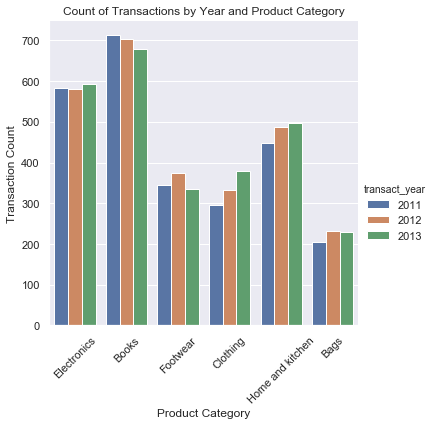

In [33]:
fig = sns.catplot(x='prod_cat', kind='count', hue='transact_year', data=eshop_df)
fig.set(xlabel='Product Category', ylabel="Transaction Count", title="Count of Transactions by Year and Product Category");
fig.set_xticklabels(rotation=45);

The same can be said when checking the store's total sales by year per product category.

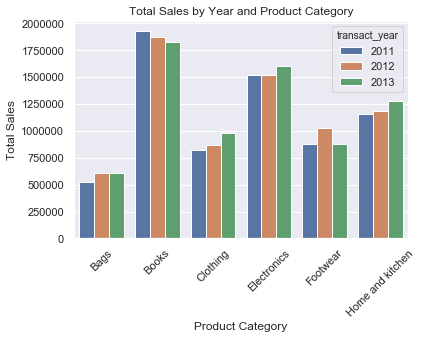

In [34]:
grouped_df = eshop_df.groupby(['prod_cat', 'transact_year']).total_amt.sum().reset_index()
fig = sns.barplot(x='prod_cat', y='total_amt', hue='transact_year', data=grouped_df)
fig.set(xlabel='Product Category', ylabel="Total Sales", title="Total Sales by Year and Product Category")
fig.set_xticklabels(fig.get_xticklabels(), rotation=45);

For Bags, Clothing and Home and Kitchen, they are the only product categories whose sales are increasing year by year. While their cumulative sales are lower than that of Books and Electronics, they are gaining traction in the E-Shop.

It is of interest to know the customers who buy from the Bags, Clothing and Home and Kitchen categories. There is a potential for these categories to grow further in sales, and knowing who the right customers are can drive this.

A new dataframe, <b>'rising_market_df'</b>, is created and is derived from the eshop_df.

In [35]:
rising_market_df = eshop_df.copy(deep=True)
rows_to_drop = rising_market_df[~rising_market_df['prod_cat'].isin(['Clothing', 'Home and kitchen', 'Bags'])].index
drop_rows_reset_index_inplace(rows_to_drop, rising_market_df)
rising_market_df.head()

,transaction_id,customer_id,transact_date,prod_sub_cat_code,prod_cat_code,qty,rate,tax,total_amt,store_type,transact_year,transact_month,birth_year,gender,city_code,prod_cat,prod_sub_cat
0,83963970126,274655,2013-12-31 00:00:00.000000,3,1,5,213,111.825,1176.825,e-Shop,2013,12,1981,M,9.0,Clothing,clothing_kids
1,51514545410,270709,2013-12-30 00:00:00.000000,1,1,5,1304,684.600,7204.600,e-Shop,2013,12,1976,M,7.0,Clothing,clothing_women
2,83941716509,273771,2013-12-30 00:00:00.000000,4,1,5,725,380.625,4005.625,e-Shop,2013,12,1981,M,2.0,Clothing,clothing_men
3,33215457342,272081,2013-12-29 00:00:00.000000,12,6,4,1079,453.180,4769.180,e-Shop,2013,12,1978,F,6.0,Home and kitchen,tools
4,9488888491,267446,2013-12-29 00:00:00.000000,1,4,2,1336,280.560,2952.560,e-Shop,2013,12,1992,M,6.0,Bags,bags_men


## 2.3. Exploring the Customers of the Rising Markets Dataset

Below is the distribution of birth years of the customers. This is not normally distributed.

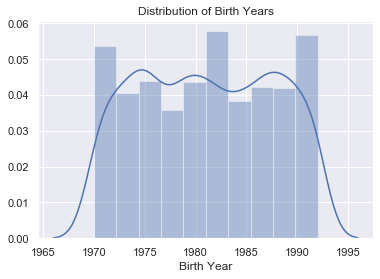

In [36]:
dist = sns.distplot(rising_market_df['birth_year'], bins=10)
dist.set(xlabel='Birth Year', title='Distribution of Birth Years');

All city codes follow the same trend. Home and Kitchen are the most bought category followd by Clothing and Bags.

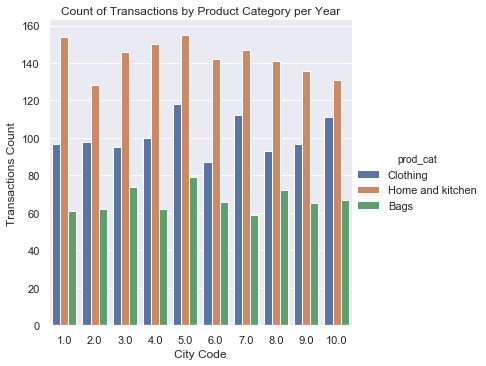

In [37]:
fig = sns.catplot(x='city_code', kind='count', hue='prod_cat', data=rising_market_df)
fig.set(xlabel='City Code', ylabel="Transactions Count", title="Count of Transactions by Product Category per Year");

### Conclusion
At this point, no significant data can be gathered from the rising market dataset, since it was the result of the transactions dataset merged with products and customers.  

Since each customer can have more than one transaction, the <b>customer must be profiled</b> based on his transaction history.

# 3. Customer Profiling

## 3.1. Pivoting the Data by Total Sales per Subcategory
Some customers have multiple transactions, and they have bought either from the same or from different subcategories. In this section, the rising_market_df is pivoted by total sales for each customer per subcategory. 

In [38]:
pivot = pd.pivot_table(rising_market_df, values='total_amt', index=['customer_id'], columns=['prod_sub_cat'],
                       aggfunc=np.sum, fill_value=0)
pivot.head()

prod_sub_cat,bags_men,bags_women,bath,clothing_kids,clothing_men,clothing_women,furnishing,kitchen,tools
customer_id,,,,,,,,,
266783,0.00,0.0,0.0,0.00,960.245,0.0,0.0,0.0,0.00
266794,2948.14,0.0,0.0,1533.74,0.000,0.0,0.0,0.0,0.00
266806,0.00,0.0,0.0,0.00,923.780,0.0,0.0,0.0,517.14
266807,0.00,0.0,0.0,0.00,495.040,0.0,0.0,0.0,0.00
266810,0.00,0.0,0.0,0.00,7542.730,0.0,0.0,0.0,1264.12


## 3.2. Joining Customer Dataset Columns to the Pivot Table
Using ```pandasql```, join the ```customer_df``` to the pivot table using the column ```customer_id```. This creates the new dataframe, ```profile_df```

In [39]:
profile_df = lambda query: sqldf(query, globals())
query = """
    SELECT
        p.*,
        c.gender,
        c.city_code,
        c.birth_year
    FROM pivot p
    INNER JOIN customer_df c
        ON c.customer_id = p.customer_id
    
"""
profile_df = profile_df(query)

Rename the subcategories columns of ```profile_df``` by adding the 'total_' prefix.

In [40]:
col_mapping = {
    'bags_men': 'total_bags_men',
    'bags_women': 'total_bags_women',
    'bath': 'total_bath',
    'clothing_kids': 'total_clothing_kids',
    'clothing_men': 'total_clothing_men',
    'clothing_women': 'total_clothing_women',
    'furnishing': 'total_furnishing',
    'kitchen': 'total_kitchen',
    'tools': 'total_tools'
}
profile_df.rename(columns=col_mapping, inplace=True)
profile_df.head()

,customer_id,total_bags_men,total_bags_women,total_bath,total_clothing_kids,total_clothing_men,total_clothing_women,total_furnishing,total_kitchen,total_tools,gender,city_code,birth_year
0,268159,779.025,0.0,327.08,8141.64,0.0,0.0,0.00,0.000,0.0,F,8.0,1970
1,270181,0.000,0.0,0.00,0.00,0.0,0.0,2302.82,0.000,0.0,F,2.0,1970
2,275152,0.000,0.0,0.00,0.00,1701.7,0.0,0.00,0.000,0.0,M,4.0,1970
3,270829,0.000,0.0,7602.40,0.00,0.0,0.0,0.00,0.000,0.0,F,8.0,1970
4,274593,0.000,0.0,0.00,0.00,0.0,0.0,0.00,2284.035,0.0,M,10.0,1970


In [41]:
profile_df.describe(include='all')

,customer_id,total_bags_men,total_bags_women,total_bath,total_clothing_kids,total_clothing_men,total_clothing_women,total_furnishing,total_kitchen,total_tools,gender,city_code,birth_year
count,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,2376,2376.000000,2376.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1222,NaN,NaN
mean,270950.167929,368.784914,361.544280,364.604423,369.708072,406.411187,349.389280,368.572843,368.256597,422.855968,NaN,5.493687,1981.135522
std,2459.351938,1202.264941,1206.009963,1156.046928,1206.322403,1278.389586,1160.346168,1148.452582,1180.379511,1257.902831,NaN,2.861277,6.596917
min,266783.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,1970.000000
25%,268805.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,3.000000,1975.000000
50%,270880.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,5.000000,1981.000000
75%,273139.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,8.000000,1987.000000


## 3.3. Exporting the Profile to CSV
Export the ```profile_df``` to CSV format. This will be fed to the R Notebook where the clustering happens.

In [42]:
exported_dataset_dir = os.path.join(dataset_dir, 'exported')
if not os.path.exists(exported_dataset_dir):
    os.mkdir(exported_dataset_dir)
    
def export_df_to_csv(df, dir, filename):
    filepath = os.path.join(dir, filename)
    df.to_csv(filepath, index=False)

In [43]:
export_df_to_csv(profile_df, exported_dataset_dir, 'profile')

# 4. Cluster Analysis

## 4.1. Mixed Data Clustering in R

### Rationale
R is the programming language used to cluster the two datasets. While python is robust and has many libraries, it simply cannot cluster mixed-data types. After researching, I used a method in R to discover the market segments of this retail store.

## 4.2. Viewing the R Notebook and R Scripts

#### R Notebook
This notebook has the steps I took for clustering. It is where I figured out the columns and the number of clusters to use. Please view this at: 

## 4.3. Joining the Cluster Results with the Datasets  
In this section, the results from the R Notebook are exported in CSV format and are then imported as pandas dataframes. They will be joined to the existing ```profile_df``` using pandasql.

In [44]:
profile_tsne_data_file = os.path.join(exported_dataset_dir, 'profile_tsne_data')
profile_tsne_df = pd.read_csv(profile_tsne_data_file)
profile_tsne_df.head()

,Unnamed: 0,X,Y,cluster,customer_id
0,1,-8.097424,40.178476,1,268159
1,2,-2.231335,4.000221,1,270181
2,3,10.922439,-32.672245,2,275152
3,4,-7.468783,40.917174,1,270829
4,5,-13.048357,1.410031,3,274593


In [45]:
profile_cluster_df = lambda query: sqldf(query, globals())
query = """
    SELECT
        p.*,
        t.X,
        t.Y,
        t.cluster
    FROM profile_df p
    INNER JOIN profile_tsne_df t
        ON p.customer_id = t.customer_id
"""
profile_cluster_df = profile_cluster_df(query)

Add a new column, 'overlap_cluster' to easily identify customers that are in overlapping clusters.

In [46]:
profile_cluster_df['overlap_cluster'] = np.nan

Change data type of columns 'city_code' and 'customer_id' to characters.

In [47]:
profile_cluster_df['city_code'].apply(str);
profile_cluster_df['customer_id'].apply(str);

# 5. Clustering Results Analysis
Now that the ```profile_cluster_df``` now has the x and y coordinates from rTSNE, use the scatterplot in seaborn's design to further differentiate the clusters.

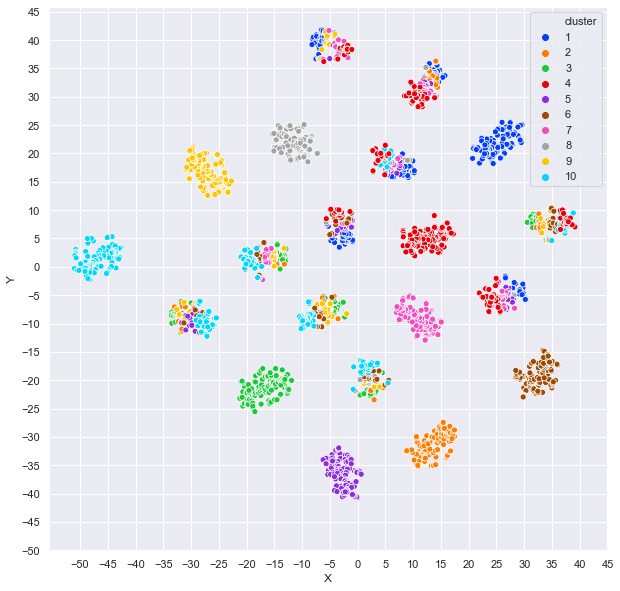

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
repeat_scatter = sns.scatterplot(x='X', y='Y', hue='cluster', data=profile_cluster_df, legend='full', palette=sns.color_palette(palette='bright'), ax=ax)
repeat_scatter.set_xticks(np.arange(-50,50,5));
repeat_scatter.set_yticks(np.arange(-50,50,5));

## 5.1. Overlapping Clusters
The image below is the same scatterplot but with the overlapping clusters encircled and labelled. Overlapping clusters are extracted by their coordinates on the scatter plot.  

There are different clusters that have overlapped or have grouped with each other. We need to find out what they have in common to form a cluster different from their originally assigned clusters.

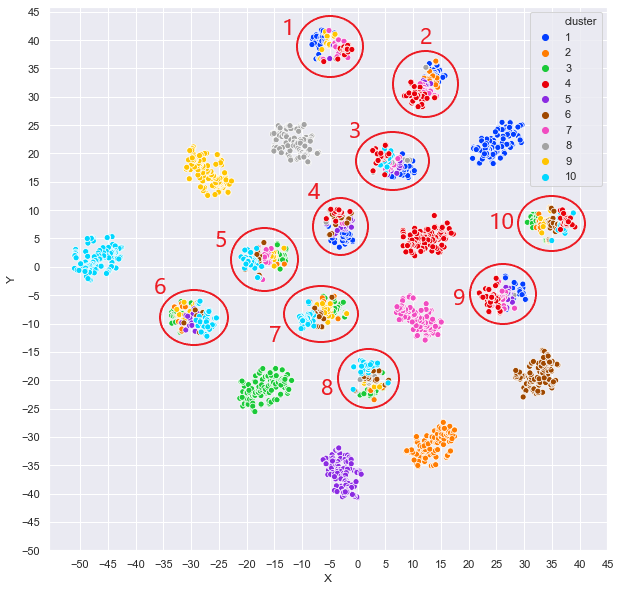

In [49]:
PATH = os.path.join(os.getcwd(), "cluster_profile_overlap.png")
Image(filename=PATH, width=650, height=650)

For each labelled overlapping cluster, assign the ranges of their X and Y coordinates. The dictionary ```overlap_df``` initially contains ```None```, but their values will be filled out later on.  

In [50]:
coordinates = {
    'overlap_1_df': {'X': [-10, 3], 'Y': [35, 44]},
    'overlap_2_df': {'X': [7, 17], 'Y': [27, 37]},
    'overlap_3_df': {'X': [1, 12], 'Y': [14, 24]},
    'overlap_4_df': {'X': [-8, 2], 'Y': [3, 13]},
    'overlap_5_df': {'X': [-23, -12], 'Y': [-4, 8]},
    'overlap_6_df': {'X': [-37, -23], 'Y': [-14, -4]},
    'overlap_7_df': {'X': [-13, 0], 'Y': [-13, -3]},
    'overlap_8_df': {'X': [-4, 8], 'Y': [-25, -14]},
    'overlap_9_df': {'X': [20, 33], 'Y': [-9, 1]},
    'overlap_10_df': {'X': [28, 42], 'Y': [3, 13]},   
}
overlap_df = {
    'overlap_1_df': None,
    'overlap_2_df': None,
    'overlap_3_df': None,
    'overlap_4_df': None,
    'overlap_5_df': None,
    'overlap_6_df': None,
    'overlap_7_df': None,
    'overlap_8_df': None,
}

The lists ```describe_columns``` and ```sub_cat_columns``` are constant variables to easily refer to them in the iteration functions of both overlapping and solid clusters. They will be used in printing out the summaries.

In [51]:
describe_columns = ['gender', 'city_code', 'birth_year', 'cluster', 'overlap_cluster']
sub_cat_columns = ['total_bags_men', 'total_bags_women', 'total_bath',
                   'total_clothing_kids', 'total_clothing_men', 'total_clothing_women',
                   'total_furnishing', 'total_kitchen', 'total_tools']

Each loop for the solid and overlapping clusters would have their summaries printed out. This function formats how they will be displayed in the output.

In [52]:
def print_cluster_summary(cluster_name, describe_df, categ_summary_df):
    print('-------------------------------------------------')
    print(cluster_name.upper(), ' ', 'DESCRIPTION')
    print('-------------------------------------------------')
    print(describe_df)
    print('-------------------------------------------------')
    print(cluster_name.upper(), ' ', 'SUB CATEGORY SUMMARY')
    print('-------------------------------------------------')
    print(categ_summary_df)
    print('-------------------------------------------------')
    print('\n', '++++++++++++++++++++++++++++++++++++++++++++++++++++', '\n')

From the ```profile_cluster_df```, the customers who belong to the overlapping clusters are extracted by using the mapped X and  Y coordinates ranges.  This subset will be the dataframe value of the dictionary key ```overlap_df[cluster]``` .  

In the ```profile_cluster_df```, customer_ids that are in the ```overlap_df[cluster]``` are assigned with their overlapping cluster names .  

Finally, print the description and the total sales per subcategory of the ```overlap_df[cluster]```.

In [53]:
for cluster, coord in coordinates.items():
    overlap_df[cluster] = profile_cluster_df[profile_cluster_df.columns]
    overlap_df[cluster] = overlap_df[cluster][(overlap_df[cluster]['X'].between(coord['X'][0], coord['X'][1])) &
                                              (overlap_df[cluster]['Y'].between(coord['Y'][0], coord['Y'][1]))
                                             ]

    # Assign the overlapping cluster number in the profile_cluster_df
    ol_cluster = 'OL' + str(cluster[8])
    profile_cluster_df.loc[profile_cluster_df['customer_id'].isin(overlap_df[cluster]['customer_id']),
                          'overlap_cluster'] = ol_cluster
    
    describe_cluster_df = overlap_df[cluster][describe_columns].describe(include='all')

    totals_list = overlap_df[cluster][sub_cat_columns].sum()
    mean_list = overlap_df[cluster][sub_cat_columns].mean()
    median_list = overlap_df[cluster][sub_cat_columns].median()
    
    categ_summary_data = zip(sub_cat_columns, totals_list, mean_list, median_list)
    overlap_categ_summary_df = pd.DataFrame(categ_summary_data, columns=['prod_sub_cat', 'total_sales', 'mean', 'median'])
    overlap_categ_summary_df.sort_values(by=['total_sales'], ascending=False, inplace=True)
    
    print_cluster_summary(cluster, describe_cluster_df, overlap_categ_summary_df)
    

-------------------------------------------------
OVERLAP_1_DF   DESCRIPTION
-------------------------------------------------
       gender  city_code   birth_year    cluster  overlap_cluster
count      99       99.0    99.000000  99.000000              0.0
unique      1        NaN          NaN        NaN              NaN
top         F        NaN          NaN        NaN              NaN
freq       99        NaN          NaN        NaN              NaN
mean      NaN        8.0  1979.646465   4.464646              NaN
std       NaN        0.0     6.751135   3.134121              NaN
min       NaN        8.0  1970.000000   1.000000              NaN
25%       NaN        8.0  1974.000000   1.000000              NaN
50%       NaN        8.0  1979.000000   4.000000              NaN
75%       NaN        8.0  1985.000000   7.000000              NaN
max       NaN        8.0  1992.000000   9.000000              NaN
-------------------------------------------------
OVERLAP_1_DF   SUB CATEGORY SUM

-------------------------------------------------
OVERLAP_6_DF   DESCRIPTION
-------------------------------------------------
       gender  city_code   birth_year     cluster overlap_cluster
count     122      122.0   122.000000  122.000000               0
unique      1        NaN          NaN         NaN               0
top         M        NaN          NaN         NaN             NaN
freq      122        NaN          NaN         NaN             NaN
mean      NaN        1.0  1981.614754    6.696721             NaN
std       NaN        0.0     6.638788    3.203535             NaN
min       NaN        1.0  1970.000000    2.000000             NaN
25%       NaN        1.0  1976.000000    3.000000             NaN
50%       NaN        1.0  1982.000000    6.000000             NaN
75%       NaN        1.0  1987.000000   10.000000             NaN
max       NaN        1.0  1992.000000   10.000000             NaN
-------------------------------------------------
OVERLAP_6_DF   SUB CATEGORY SUM

This table summarizes the printed results. The <b>Cluster Details</b> describe the profiles of the overlapping customers, while the <b>Top Selling Subcategories</b> are the top 3 selling subcategories.

<table>
    <thead>
        <tr style='height:20px;'>
            <td dir="ltr" colspan="7"><center><b>Cluster Details</b></center></td>
            <td dir="ltr" colspan="3"><center><b>Top Selling Subcategories</b></center></td>
        </tr>
        <tr style='height:20px;'>
            <td><center><b>Overlapping Cluster</b></center></td>
            <td><center><b>Count</b></center></td>
            <td><center><b>Mean Birth Year</b></center></td>
            <td dir="ltr"><center><b>Mean Age<br>(2013 - birth year)</b></center></td>
            <td><center><b>Median Birth Year</b></center></td>
            <td><center><b>Gender</b></center></td>
            <td><center><b>City Code</b></center></td>
            <td><center><b>1st Subcategory</b></center></td>
            <td><center><b>2nd Subcategory</b></center></td>
            <td><center><b>3rd Subcategory</b></center></td>
        </tr>
    </thead>
    <tbody>
        <tr style='height:20px;'>
            <td>1</td>
            <td>99</td>
            <td>1980</td>
            <td>33</td>
            <td>1979</td>
            <td>F</td>
            <td>8</td>
            <td>kitchen</td>
            <td>bath</td>
            <td>bags_women</td>
        </tr>
        <tr style='height:20px;'>
            <td>2</td>
            <td>111</td>
            <td>1981</td>
            <td>32</td>
            <td>1982</td>
            <td>F</td>
            <td>4</td>
            <td>tools</td>
            <td>bags_women</td>
            <td>kitchen</td>
        </tr>
        <tr style='height:20px;'>
            <td>3</td>
            <td>108</td>
            <td>1982</td>
            <td>31</td>
            <td>1983</td>
            <td>F</td>
            <td>3</td>
            <td>clothing_kids</td>
            <td>tools</td>
            <td>clothing_men</td>
        </tr>
        <tr style='height:20px;'>
            <td>4</td>
            <td>96</td>
            <td>1980</td>
            <td>33</td>
            <td>1981</td>
            <td>F</td>
            <td>2</td>
            <td>clothing_men</td>
            <td>furnishing</td>
            <td>clothing_kids</td>
        </tr>
        <tr style='height:20px;'>
            <td>5</td>
            <td>117</td>
            <td>1982</td>
            <td>31</td>
            <td>1982</td>
            <td>M</td>
            <td>10</td>
            <td>clothing_men</td>
            <td>furnishing</td>
            <td class="s3 softmerge">
                <div class="softmerge-inner" style="width: 198px; left: -1px;">clothing_women</div>
            </td>
        </tr>
        <tr style='height:20px;'>
            <td>6</td>
            <td>122</td>
            <td>1982</td>
            <td>31</td>
            <td>1982</td>
            <td>M</td>
            <td>1</td>
            <td>clothing_men</td>
            <td>tools</td>
            <td>clothing_kids</td>
        </tr>
        <tr style='height:20px;'>
            <td>7</td>
            <td>113</td>
            <td>1981</td>
            <td>32</td>
            <td>1979</td>
            <td>M</td>
            <td>6</td>
            <td>tools</td>
            <td class="s2 softmerge">
                <div class="softmerge-inner" style="width: 97px; left: -1px;">clothing_women</div>
            </td>
            <td>clothing_men</td>
        </tr>
        <tr style='height:20px;'>
            <td>8</td>
            <td>103</td>
            <td>1981</td>
            <td>32</td>
            <td>1981</td>
            <td>M</td>
            <td>9</td>
            <td>bags_men</td>
            <td class="s2 softmerge">
                <div class="softmerge-inner" style="width: 97px; left: -1px;">clothing_women</div>
            </td>
            <td>furnishing</td>
        </tr>
        <tr style='height:20px;'>
            <td>9</td>
            <td>114</td>
            <td>1982</td>
            <td>31</td>
            <td>1982</td>
            <td>F</td>
            <td>6</td>
            <td>bath</td>
            <td>bags_men</td>
            <td>furnishing</td>
        </tr>
        <tr style='height:20px;'>
            <td>10</td>
            <td>111</td>
            <td>1982</td>
            <td>31</td>
            <td>1981</td>
            <td>M</td>
            <td>7</td>
            <td>clothing_men</td>
            <td class="s2 softmerge">
                <div class="softmerge-inner" style="width: 97px; left: -1px;">clothing_women</div>
            </td>
            <td>tools</td>
        </tr>
    </tbody>
</table>

## 5.2. Solid Clusters
Solid clusters are the clusters of the same color that have stuck together. The cell does the same as the one for overlapping clusters. However, this time, customers belonging to solid clusters are extracted by specifying their ```cluster``` number and if their ```overlap_cluster``` is ```Null```.

In [54]:
for i in range(1, 11):
    solid_cluster = profile_cluster_df[(profile_cluster_df['cluster'] == i) &
                                       (profile_cluster_df['overlap_cluster'].isnull())
                                      ]
    
    describe_cluster_df = solid_cluster[describe_columns].describe(include='all')
    
    totals_list = solid_cluster[sub_cat_columns].sum()
    mean_list = solid_cluster[sub_cat_columns].mean()
    median_list = solid_cluster[sub_cat_columns].median()
    
    categ_summary_data = zip(sub_cat_columns, totals_list, mean_list, median_list)
    solid_categ_summary_df = pd.DataFrame(categ_summary_data, columns=['prod_sub_cat', 'total_sales', 'mean', 'median'])
    solid_categ_summary_df.sort_values(by=['total_sales'], ascending=False, inplace=True)
    
    cluster_name = 'SOLID CLUSTER # {}'.format(str(i))
    
    print_cluster_summary(cluster_name, describe_cluster_df, solid_categ_summary_df)

-------------------------------------------------
SOLID CLUSTER # 1   DESCRIPTION
-------------------------------------------------
       gender  city_code   birth_year  cluster overlap_cluster
count     127      127.0   127.000000    127.0               0
unique      1        NaN          NaN      NaN               0
top         F        NaN          NaN      NaN             NaN
freq      127        NaN          NaN      NaN             NaN
mean      NaN        5.0  1981.330709      1.0             NaN
std       NaN        0.0     6.795254      0.0             NaN
min       NaN        5.0  1970.000000      1.0             NaN
25%       NaN        5.0  1975.000000      1.0             NaN
50%       NaN        5.0  1982.000000      1.0             NaN
75%       NaN        5.0  1987.000000      1.0             NaN
max       NaN        5.0  1992.000000      1.0             NaN
-------------------------------------------------
SOLID CLUSTER # 1   SUB CATEGORY SUMMARY
---------------------

-------------------------------------------------
SOLID CLUSTER # 7   DESCRIPTION
-------------------------------------------------
       gender  city_code   birth_year  cluster overlap_cluster
count     124      124.0   124.000000    124.0               0
unique      1        NaN          NaN      NaN               0
top         F        NaN          NaN      NaN             NaN
freq      124        NaN          NaN      NaN             NaN
mean      NaN       10.0  1980.975806      7.0             NaN
std       NaN        0.0     6.399268      0.0             NaN
min       NaN       10.0  1970.000000      7.0             NaN
25%       NaN       10.0  1976.000000      7.0             NaN
50%       NaN       10.0  1981.000000      7.0             NaN
75%       NaN       10.0  1986.250000      7.0             NaN
max       NaN       10.0  1992.000000      7.0             NaN
-------------------------------------------------
SOLID CLUSTER # 7   SUB CATEGORY SUMMARY
---------------------

### 5.2.1. Solid Clusters Summary
This table summarizes the customer details and top selling subcategories of the solid clusters.

<table>
    <thead>
        <tr style='height:20px;'>
            <td dir="ltr" colspan="7"><center><b>Cluster Details</b></center></td>
            <td dir="ltr" colspan="3"><center><b>Top Selling Subcategories</b></center></td>
        </tr>
        <tr style='height:20px;'>
            <td><center><b>Solid Cluster</b></center></td>
            <td><center><b>Count</b></center></td>
            <td><center><b>Mean Birth Year</b></center></td>
            <td dir="ltr"><center><b>Mean Age<br>(2013 - birth year)</b></center></td>
            <td><center><b>Median Birth Year</b></center></td>
            <td><center><b>Gender</b></center></td>
            <td><center><b>City Code</b></center></td>
            <td><center><b>1st Subcategory</b></center></td>
            <td><center><b>2nd Subcategory</b></center></td>
            <td><center><b>3rd Subcategory</b></center></td>
        </tr>
    </thead>
    <tbody>
        <tr style='height:20px;'>
            <td>1</td>
            <td>127</td>
            <td>1981</td>
            <td>33</td>
            <td>1982</td>
            <td>F</td>
            <td>5</td>
            <td>tools</td>
            <td class="s2 softmerge">
                <div class="softmerge-inner" style="width: 97px; left: -1px;">clothing_women</div>
            </td>
            <td>clothing_men</td>
        </tr>
        <tr style='height:20px;'>
            <td>2</td>
            <td>130</td>
            <td>1980</td>
            <td>32</td>
            <td>1980</td>
            <td>M</td>
            <td>4</td>
            <td>furnishing</td>
            <td class="s2 softmerge">
                <div class="softmerge-inner" style="width: 97px; left: -1px;">clothing_women</div>
            </td>
            <td>kitchen</td>
        </tr>
        <tr style='height:20px;'>
            <td>3</td>
            <td>142</td>
            <td>1980</td>
            <td>31</td>
            <td>1979</td>
            <td>M</td>
            <td>5</td>
            <td>bath</td>
            <td>clothing_kids</td>
            <td>bags_women</td>
        </tr>
        <tr style='height:20px;'>
            <td>4</td>
            <td>126</td>
            <td>1981</td>
            <td>33</td>
            <td>1981</td>
            <td>F</td>
            <td>7</td>
            <td>clothing_kids</td>
            <td>furnishing</td>
            <td>bath</td>
        </tr>
        <tr style='height:20px;'>
            <td>5</td>
            <td>124</td>
            <td>1982</td>
            <td>31</td>
            <td>1981</td>
            <td>F</td>
            <td>1</td>
            <td>tools</td>
            <td>clothing_kids</td>
            <td>furnishing</td>
        </tr>
        <tr style='height:20px;'>
            <td>6</td>
            <td>120</td>
            <td>1981</td>
            <td>31</td>
            <td>1981</td>
            <td>M</td>
            <td>2</td>
            <td>kitchen</td>
            <td>bags_women</td>
            <td>clothing_kids</td>
        </tr>
        <tr style='height:20px;'>
            <td>7</td>
            <td>124</td>
            <td>1981</td>
            <td>32</td>
            <td>1981</td>
            <td>F</td>
            <td>10</td>
            <td>clothing_kids</td>
            <td>bags_women</td>
            <td class="s3 softmerge">
                <div class="softmerge-inner" style="width: 198px; left: -1px;">clothing_women</div>
            </td>
        </tr>
        <tr style='height:20px;'>
            <td>8</td>
            <td>125</td>
            <td>1981</td>
            <td>32</td>
            <td>1981</td>
            <td>F</td>
            <td>9</td>
            <td>bags_men</td>
            <td>bath</td>
            <td>clothing_men</td>
        </tr>
        <tr style='height:20px;'>
            <td>9</td>
            <td>135</td>
            <td>1981</td>
            <td>31</td>
            <td>1982</td>
            <td>M</td>
            <td>8</td>
            <td>kitchen</td>
            <td>clothing_men</td>
            <td class="s3 softmerge">
                <div class="softmerge-inner" style="width: 198px; left: -1px;">clothing_women</div>
            </td>
        </tr>
        <tr style='height:20px;'>
            <td>10</td>
            <td>129</td>
            <td>1982</td>
            <td>31</td>
            <td>1982</td>
            <td>M</td>
            <td>3</td>
            <td>bags_men</td>
            <td>tools</td>
            <td>kitchen</td>
        </tr>
    </tbody>
</table>

# 6. Recommendations

The clustering analysis of this study was initialized with 10 clusters, but based on the scatterplot, there are 10 additional overlapping clusters. <b>20 market segments have then been identified</b>.

The customers have been grouped into 20 market segments. It would be ideal to learn more about their behavior and their buying patterns. After studying them, create promotions and bundles to drive sales for each target market. Since these customers bought from the e-shop, put out recommendations based on their clusters.

All customers in the 20 clusters are in their early thirties (30-33) but each cluster has different buying priorities. Here are some clusters that I was able to describe. 

<table>
    <thead>
        <tr style='height:20px;'>
            <td dir="ltr" colspan="7"><center><b>Cluster Details</b></center></td>
            <td dir="ltr" colspan="3"><center><b>Top Selling Subcategories</b></center></td>
        </tr>
        <tr style='height:20px;'>
            <td><center><b>Overlapping Cluster</b></center></td>
            <td><center><b>Count</b></center></td>
            <td><center><b>Mean Birth Year</b></center></td>
            <td dir="ltr"><center><b>Mean Age<br>(2013 - birth year)</b></center></td>
            <td><center><b>Median Birth Year</b></center></td>
            <td><center><b>Gender</b></center></td>
            <td><center><b>City Code</b></center></td>
            <td><center><b>1st Subcategory</b></center></td>
            <td><center><b>2nd Subcategory</b></center></td>
            <td><center><b>3rd Subcategory</b></center></td>
            <td><center><b>Description</b></center></td>
            <td><center><b>Suggestion</b></center></td>
        </tr>
    </thead>
    <tbody>
        <tr style='height:20px;'>
            <td>1</td>
            <td>99</td>
            <td>1980</td>
            <td>33</td>
            <td>1979</td>
            <td>F</td>
            <td>8</td>
            <td>kitchen</td>
            <td>bath</td>
            <td>bags_women</td>
            <td>Women who are furnishing their kitchen and bath. They might occasionally buys some bags.</td>
            <td>Bundle kitchen and bath items. Recommend items that can be used for both rooms (shelves, towels, mats).</td>
        </tr>
        <tr style='height:20px;'>
            <td>4</td>
            <td>96</td>
            <td>1980</td>
            <td>33</td>
            <td>1981</td>
            <td>F</td>
            <td>2</td>
            <td>clothing_men</td>
            <td>furnishing</td>
            <td>clothing_kids</td>
            <td>Women who buy items for their family members.</td>
            <td>Bundle matching father and son clothes. Recommend some home improvement furniture.</td>
        </tr>
    </tbody>
</table>

<table>
    <thead>
        <tr style='height:20px;'>
            <td dir="ltr" colspan="7"><center><b>Cluster Details</b></center></td>
            <td dir="ltr" colspan="3"><center><b>Top Selling Subcategories</b></center></td>
        </tr>
        <tr style='height:20px;'>
            <td><center><b>Solid Cluster</b></center></td>
            <td><center><b>Count</b></center></td>
            <td><center><b>Mean Birth Year</b></center></td>
            <td dir="ltr"><center><b>Mean Age<br>(2013 - birth year)</b></center></td>
            <td><center><b>Median Birth Year</b></center></td>
            <td><center><b>Gender</b></center></td>
            <td><center><b>City Code</b></center></td>
            <td><center><b>1st Subcategory</b></center></td>
            <td><center><b>2nd Subcategory</b></center></td>
            <td><center><b>3rd Subcategory</b></center></td>
            <td><center><b>Description</b></center></td>
            <td><center><b>Suggestion</b></center></td>
        </tr>
    </thead>
    <tbody>
        <tr style='height:20px;'>
            <td>4</td>
            <td>126</td>
            <td>1981</td>
            <td>33</td>
            <td>1981</td>
            <td>F</td>
            <td>7</td>
            <td>clothing_kids</td>
            <td>furnishing</td>
            <td>bath</td>
            <td>Mothers who have kids at home and are furnishing their house.</td>
            <td>Recommend kid's clothes and kid-friendly furniture.</td>
        </tr>
        <tr style='height:20px;'>
            <td>7</td>
            <td>124</td>
            <td>1981</td>
            <td>32</td>
            <td>1981</td>
            <td>F</td>
            <td>10</td>
            <td>clothing_kids</td>
            <td>bags_women</td>
            <td>clothing_women</td>
            <td>Mothers who buy clothes and accessories for them and their child.</td>
            <td>Bundle mother and child clothes and accessories. Recommend matching items so both persons would have the same style.</td>
        </tr>
        <tr style='height:20px;'>
            <td>8</td>
            <td>125</td>
            <td>1981</td>
            <td>32</td>
            <td>1981</td>
            <td>F</td>
            <td>9</td>
            <td>bags_men</td>
            <td>bath</td>
            <td>clothing_men</td>
            <td>Women who are buying items that will improve the style and grooming of men.</td>
            <td>Recommend gift-sets for men.</td>
        </tr>
    </tbody>
</table>

# 7. Further Improvements

This study is only focused on e-shop customers who have bought items from the clothes, home and kitchen and bags categories. If machine specifications can carry the workload, it would be good to cluster the whole dataset. This way, we can understand the the behavior of customers from different sales channels.  

To effectively understand customer behavior, the dataset can have the following data:    
1. Marital Status - To know if a customer is buying it for himself or for someone.    
2. Gender Identity - To understand why some customers are buying items of the opposite sex. Are they going to use it for themselves or give it to someone?  
3. Purpose - What exactly are they going to use the items for? Were the items boughts as gifts, personal collections, hobbies or on a whim?  
4. The items themselves - It is not enough that the dataset has subcategories. The products must be identified to understand why they are bought.  